In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV


#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open('test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)
    
print(len(train_ind),len(test_ind))    


70 30


/tmp/ipykernel_221263/2691449218.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  test_ind = pickle.load(handle)
/tmp/ipykernel_221263/2691449218.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is th

In [3]:
len(train_ind)*len(glob('H*')),len(test_ind)*len(glob('H*'))

(420, 180)

In [4]:
len(train_ind)*len([i for i in glob('H*') if '12' not in i]),len(test_ind)*len([i for i in glob('H*') if '12' not in i])

(350, 150)

In [28]:
train = []
test = []



recover_train = []
recover_test = []

traincnt = 0
testcnt = 0
for i in sorted(glob('H*')):
    if '12' not in i:
        for j in glob(os.path.join(i,'H*')):
            for k in train_ind:
                if f"{k:.2f}" in j:
                    traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                    train.append(traindf)
                    recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                    traincnt+=1
                    
            for l in test_ind:
                if f"{l:.2f}" in j:
                    testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                    test.append(testdf)                    
                    recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                    testcnt+=1

In [6]:
train_df = pd.concat(train)
test_df = pd.concat(test)

In [7]:
X_train = train_df.drop(columns=['Pair_Energies']).values
X_test = test_df.drop(columns=['Pair_Energies']).values

y_train = train_df['Pair_Energies'].values
y_test = test_df['Pair_Energies'].values

In [8]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [9]:
from xgboost import XGBRegressor
# model=XGBRegressor(reg_lambda=0.3,max_depth=100,min_child_weight=5)
kwargs = {'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': np.nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.001,
 'reg_lambda': 1e-06,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}
model=XGBRegressor(**kwargs)
model.fit(X_train,y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

# params = {'max_depth': [1, 10, 100],
#           'n_estimators': [100, 500, 1000],
#           'reg_lambda': [1e-6, 1e-3,1e-1],
#           'reg_alpha': [1e-6, 1e-3,1e-1]}

# model = XGBRegressor()
# grid = GridSearchCV(estimator=model, 
#                    param_grid=params,
#                    scoring='r2', 
#                    verbose=1000,n_jobs=12).fit(X_train,y_train)


# gmodel=grid.best_estimator_
# y_pred_train=gmodel.predict(X_train)
# y_pred_test=gmodel.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")



R2: 0.9915,0.9812
RMSE (mEh): 0.1237,0.1941


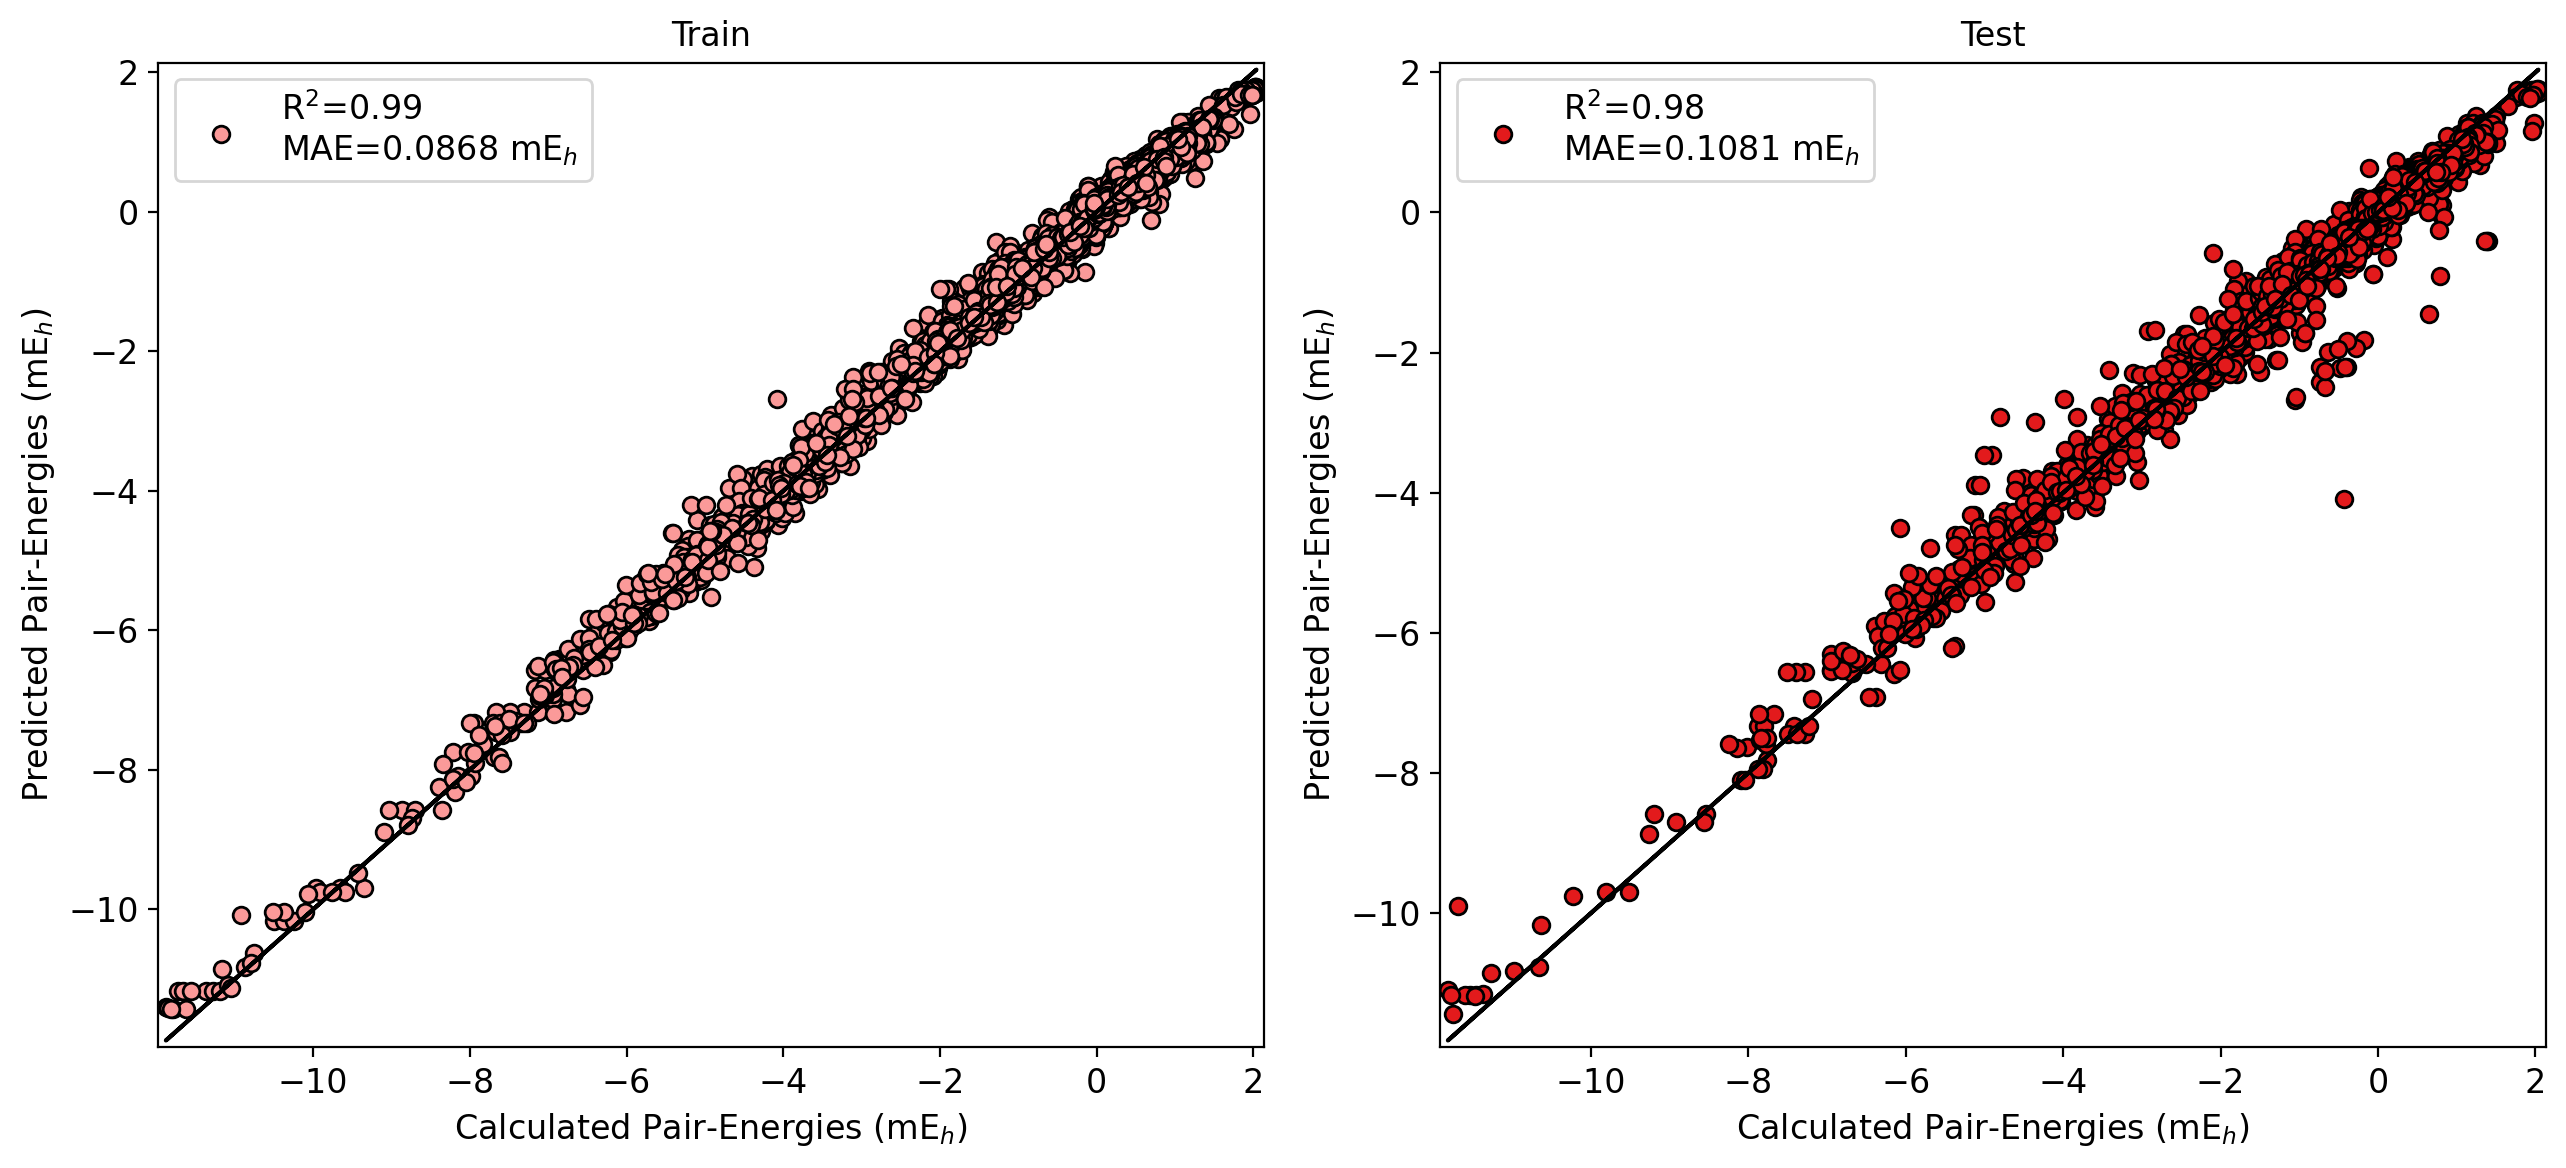

In [10]:
pal = sns.color_palette("Paired")
font=12
plt.rc('font', size=font)          # controls default text sizes
plt.rc('axes', titlesize=font)     # fontsize of the axes title
plt.rc('axes', labelsize=font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font)    # fontsize of the tick labels
plt.rc('legend', fontsize=font)    # legend fontsize
plt.rc('figure', titlesize=font)  # fontsize of the figure title
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,6))
scale=1e-1
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.2f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" mE$_{h}$",color=pal[4],edgecolors='k')
ax1.plot(1e3*y_train,1e3*y_train,'k-')
ax1.set_xlim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_ylim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax1.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.2f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" mE$_{h}$",color=pal[5],edgecolors='k')
ax2.plot(1e3*y_test,1e3*y_test,'k-')
ax2.set_xlim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_ylim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax2.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax2.legend()

plt.tight_layout()
#plt.savefig('images/H2n_parity.png',dpi=300,bbox_inches='tight')
plt.show()

In [41]:
testcntrcvr = 0
recover_test_list = []
recover_test_E2 = []
for i,j,k,l in recover_test:
    init_test = testcntrcvr
    testcntrcvr+=l
    recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
    recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))


traincntrcvr = 0
recover_train_list = []
recover_train_E2 = []
for i,j,k,l in recover_train:
    init_train = traincntrcvr
    traincntrcvr+=l
    recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
    recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))

In [133]:
traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'H$_{2n}$',1:'Radius ($\AA$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
#.astype({'H$_{2n}$':str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'H$_{2n}$',1:'Radius ($\AA$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
#.astype({'H$_{2n}$':str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})


traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
traincorrE2['E2']=np.zeros(len(traincorrE2))

traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[['H$_{2n}$','Radius ($\AA$)']].values]

for i in traincorrE2.index:
    hn, r = i.split('_')
    energy_df = pd.read_excel(f"{hn}_chain/{hn}_{r}/{hn}_{r}_energies.xlsx",index_col=0)
    traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values

traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']

traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)


testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
testcorrE2['E2']=np.zeros(len(testcorrE2))

testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[['H$_{2n}$','Radius ($\AA$)']].values]

for i in testcorrE2.index:
    hn, r = i.split('_')
    energy_df = pd.read_excel(f"{hn}_chain/{hn}_{r}/{hn}_{r}_energies.xlsx",index_col=0)
    testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values

testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']

testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)

In [157]:
traincaspt2melt = traincorrE2.melt(id_vars=['H$_{2n}$','Radius ($\AA$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Radius ($\AA$)':float,'value':float})
testcaspt2melt = testcorrE2.melt(id_vars=['H$_{2n}$','Radius ($\AA$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Radius ($\AA$)':float,'value':float})

In [155]:
trueE2=pd.concat([traincorrE2,testcorrE2]).astype({'Radius ($\AA$)':float,'E$_{\text{CASPT2}}^{\text{Calculated}}$':float})

In [201]:
mean_absolute_error(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(0.8767153127255763)

In [202]:
mean_absolute_error(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(0.6153313359333645)

In [161]:
pairedcp=sns.color_palette('Paired')

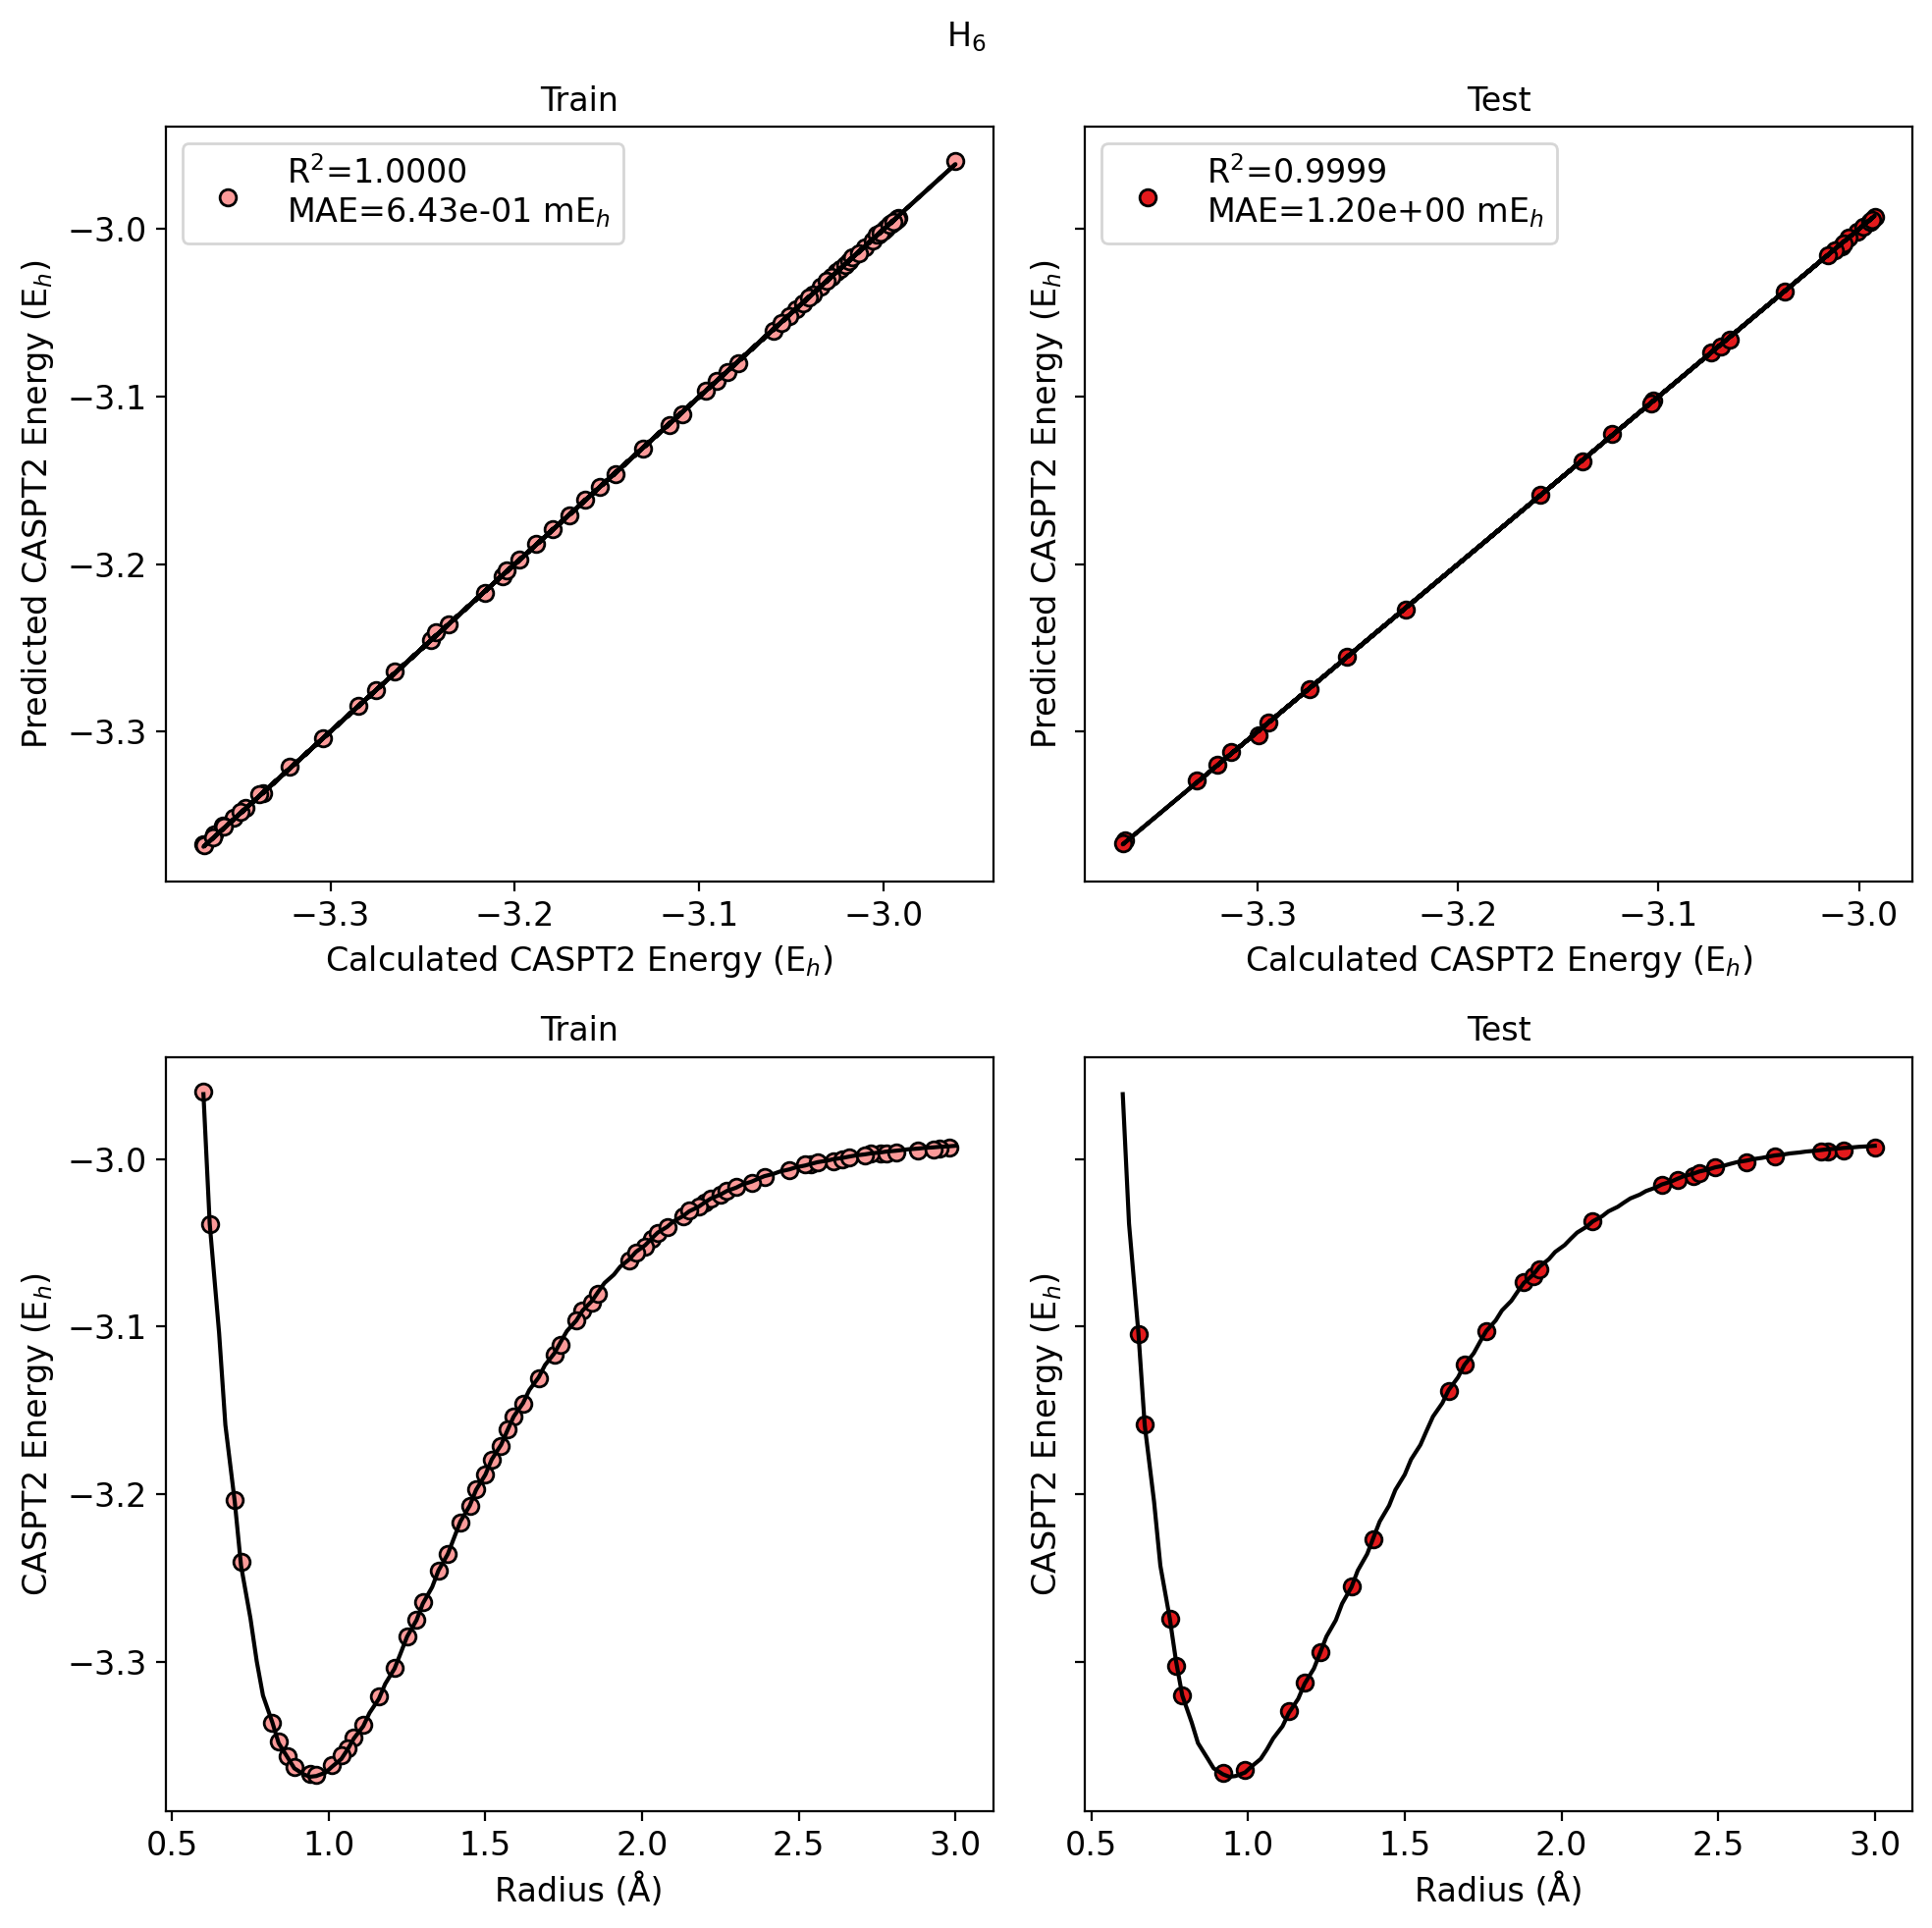

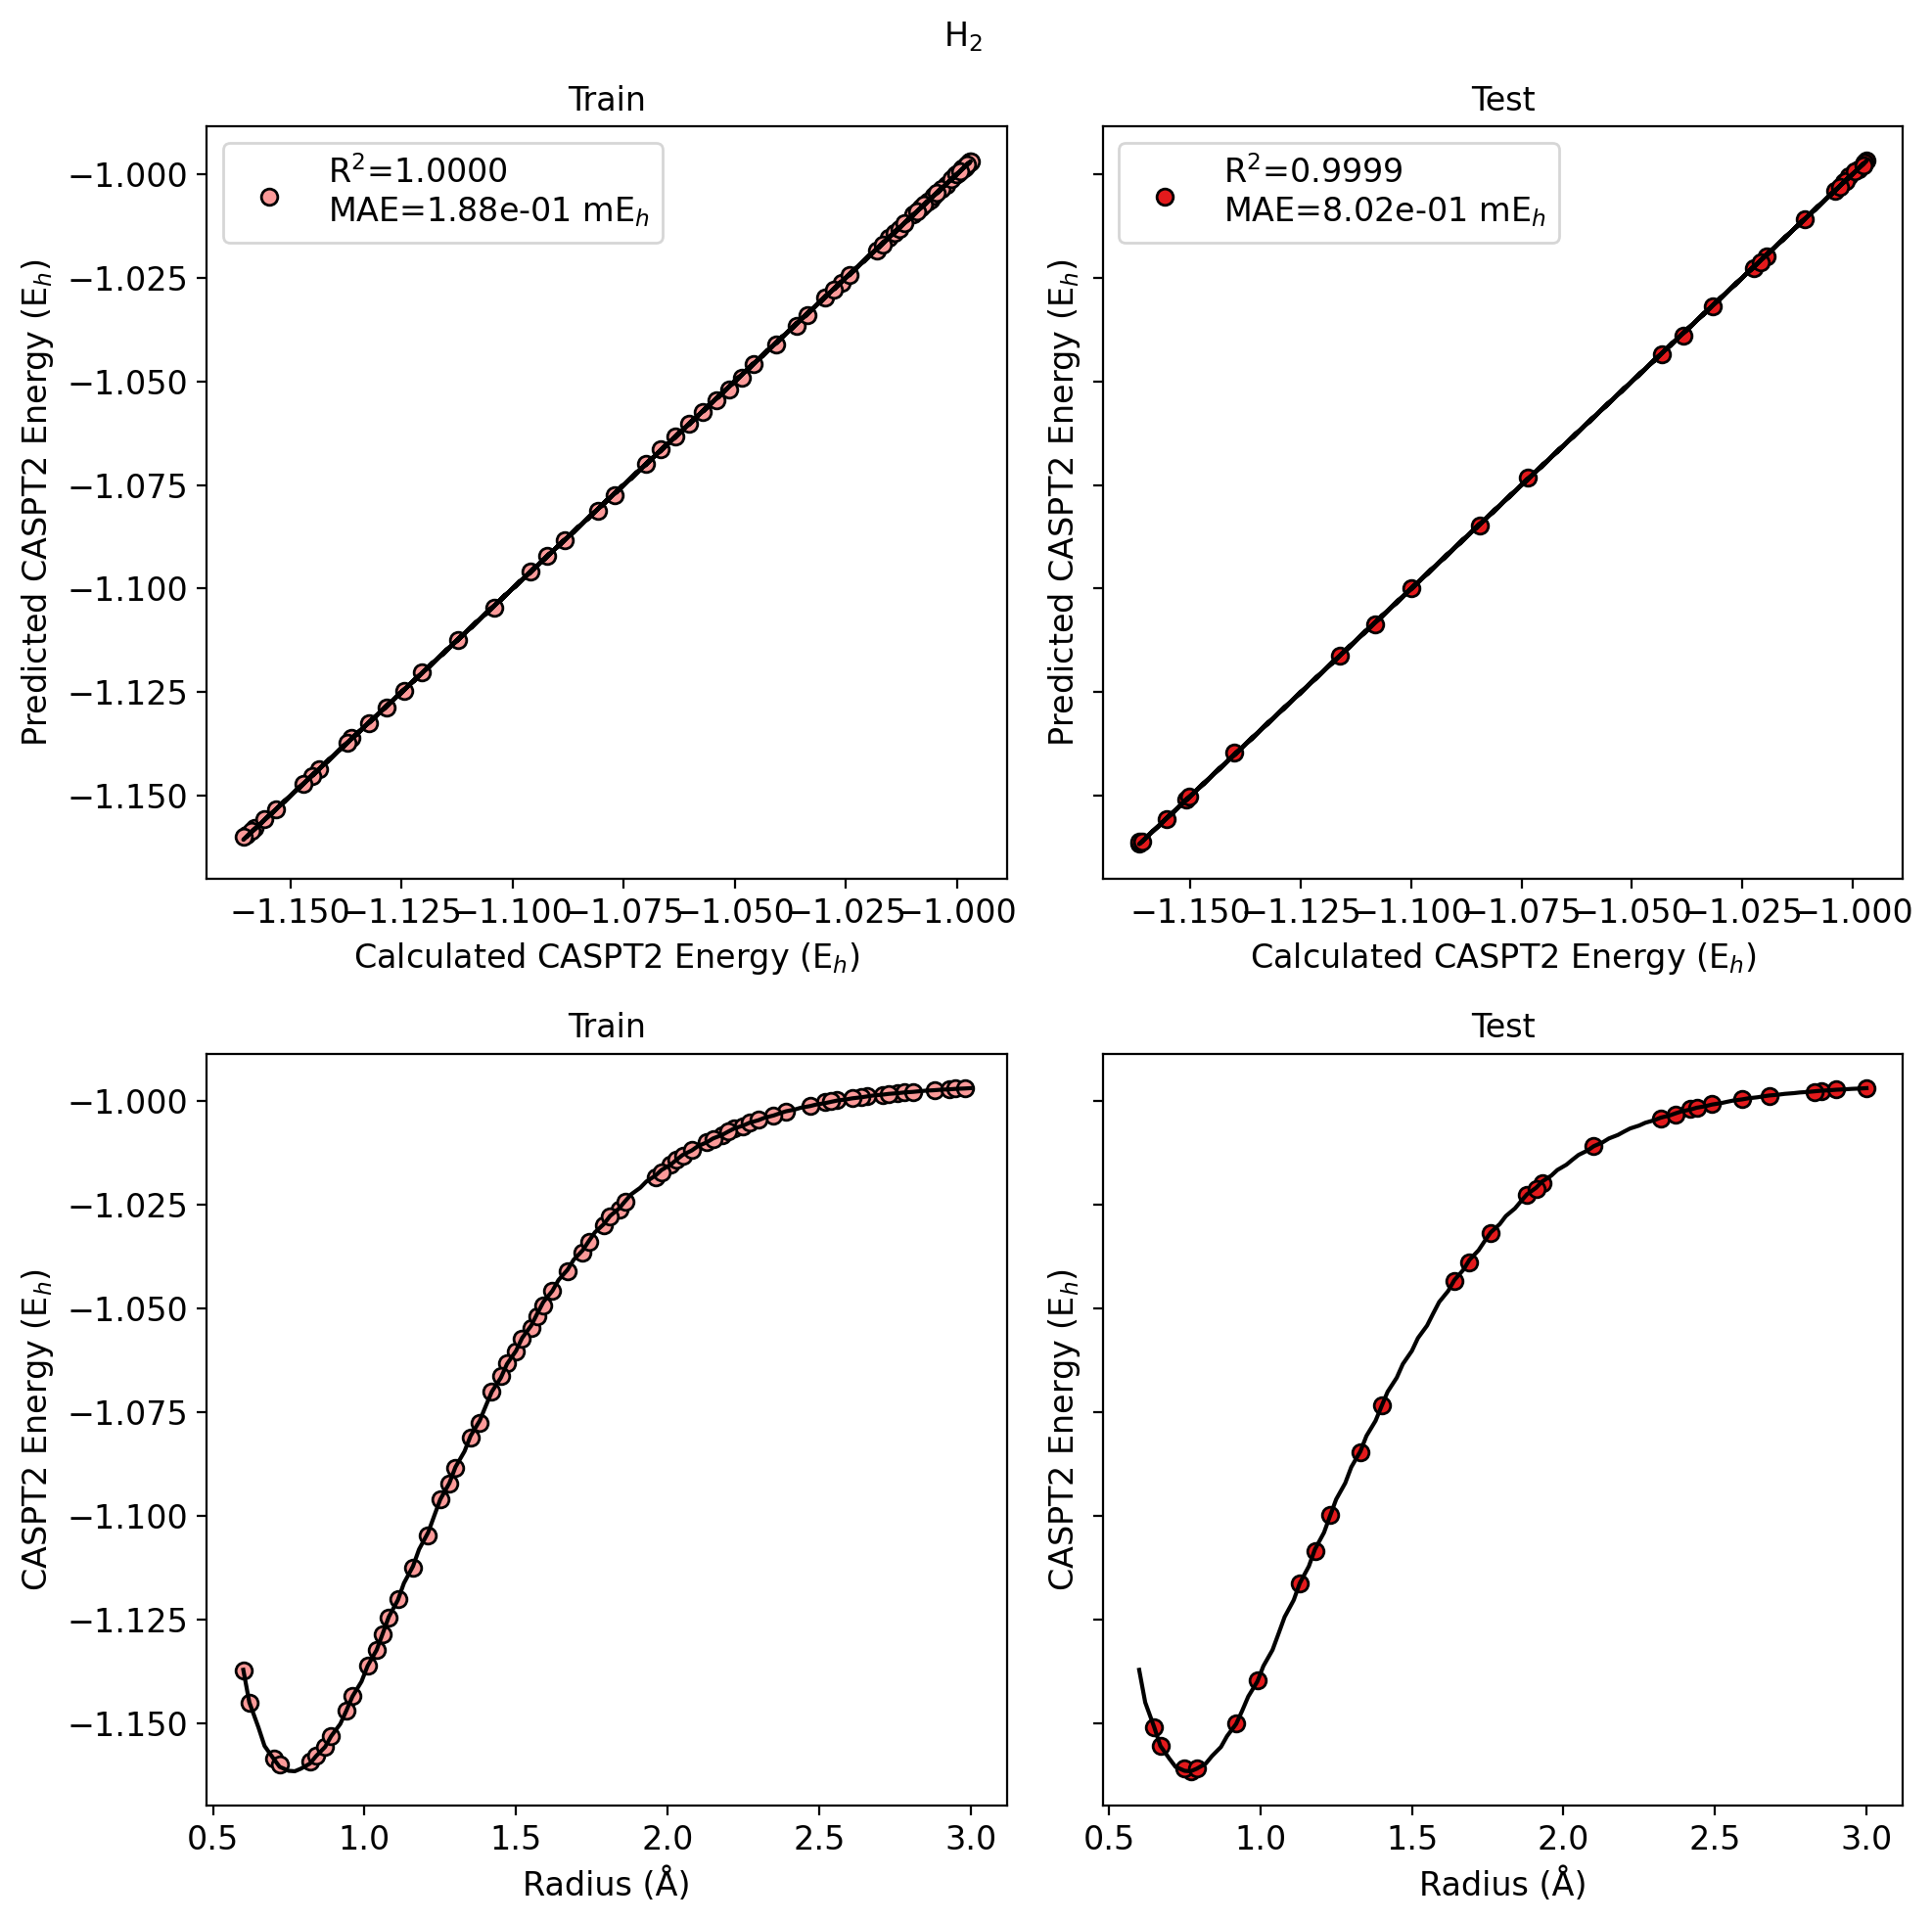

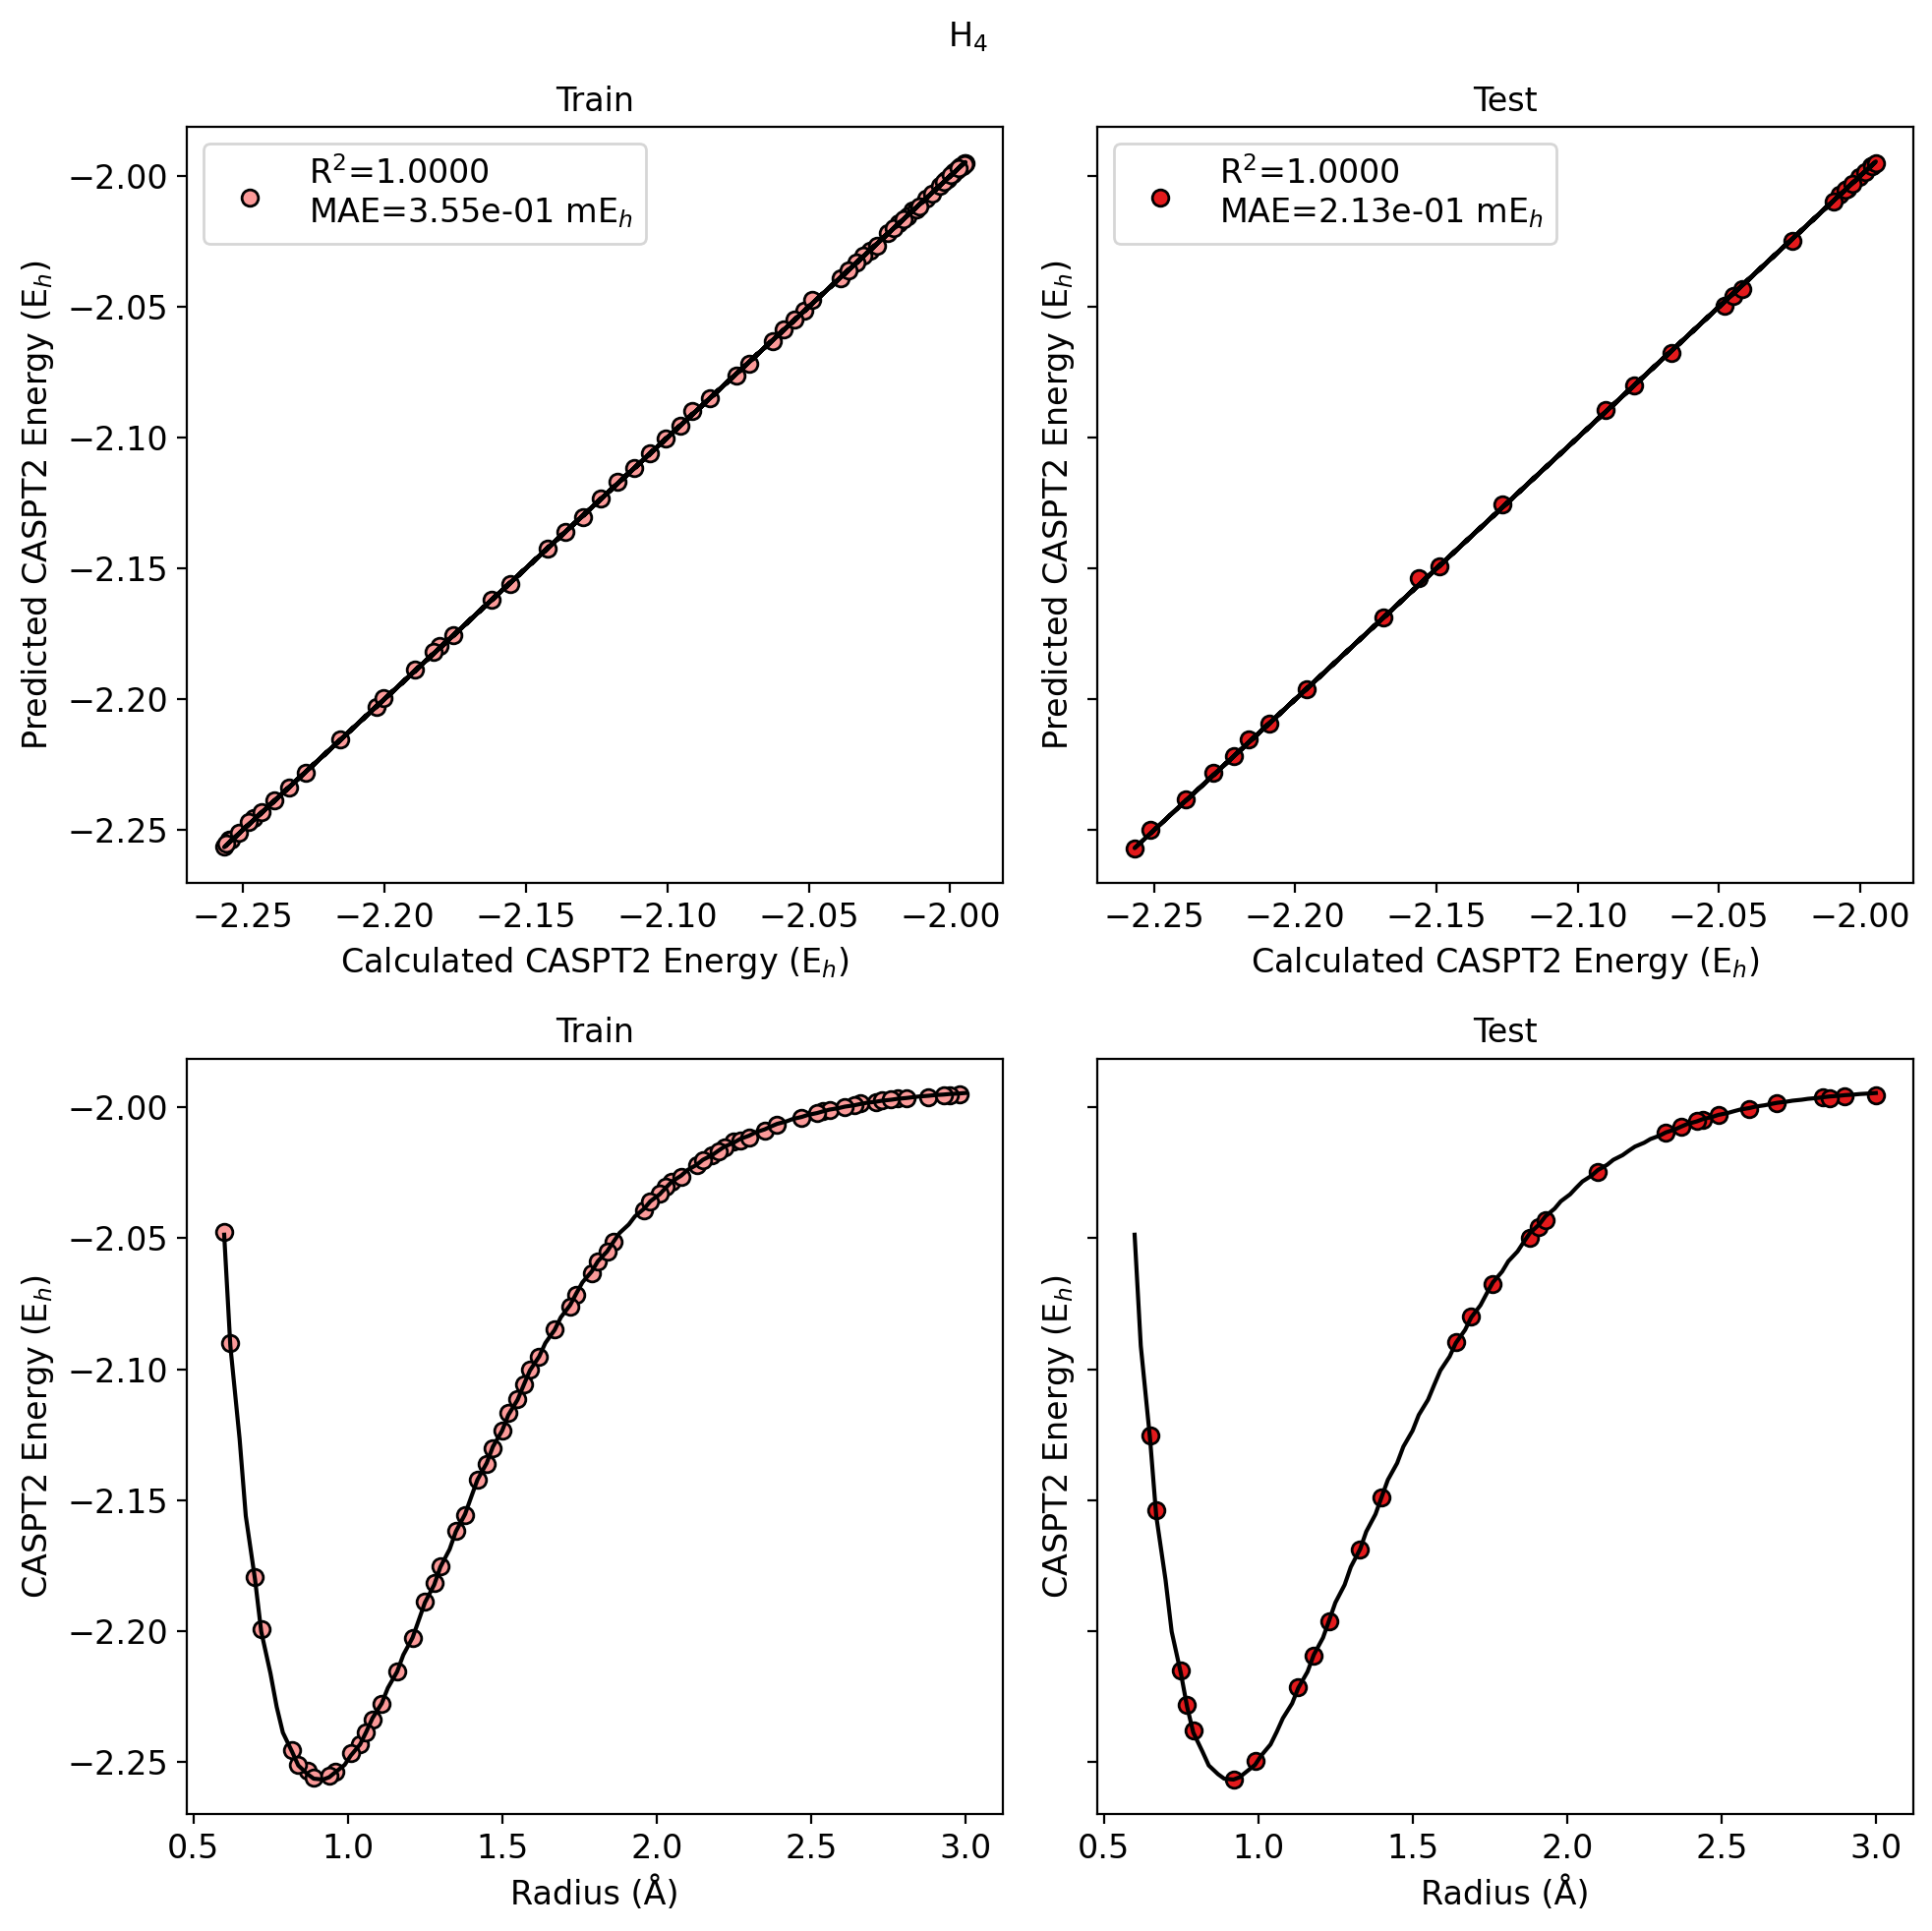

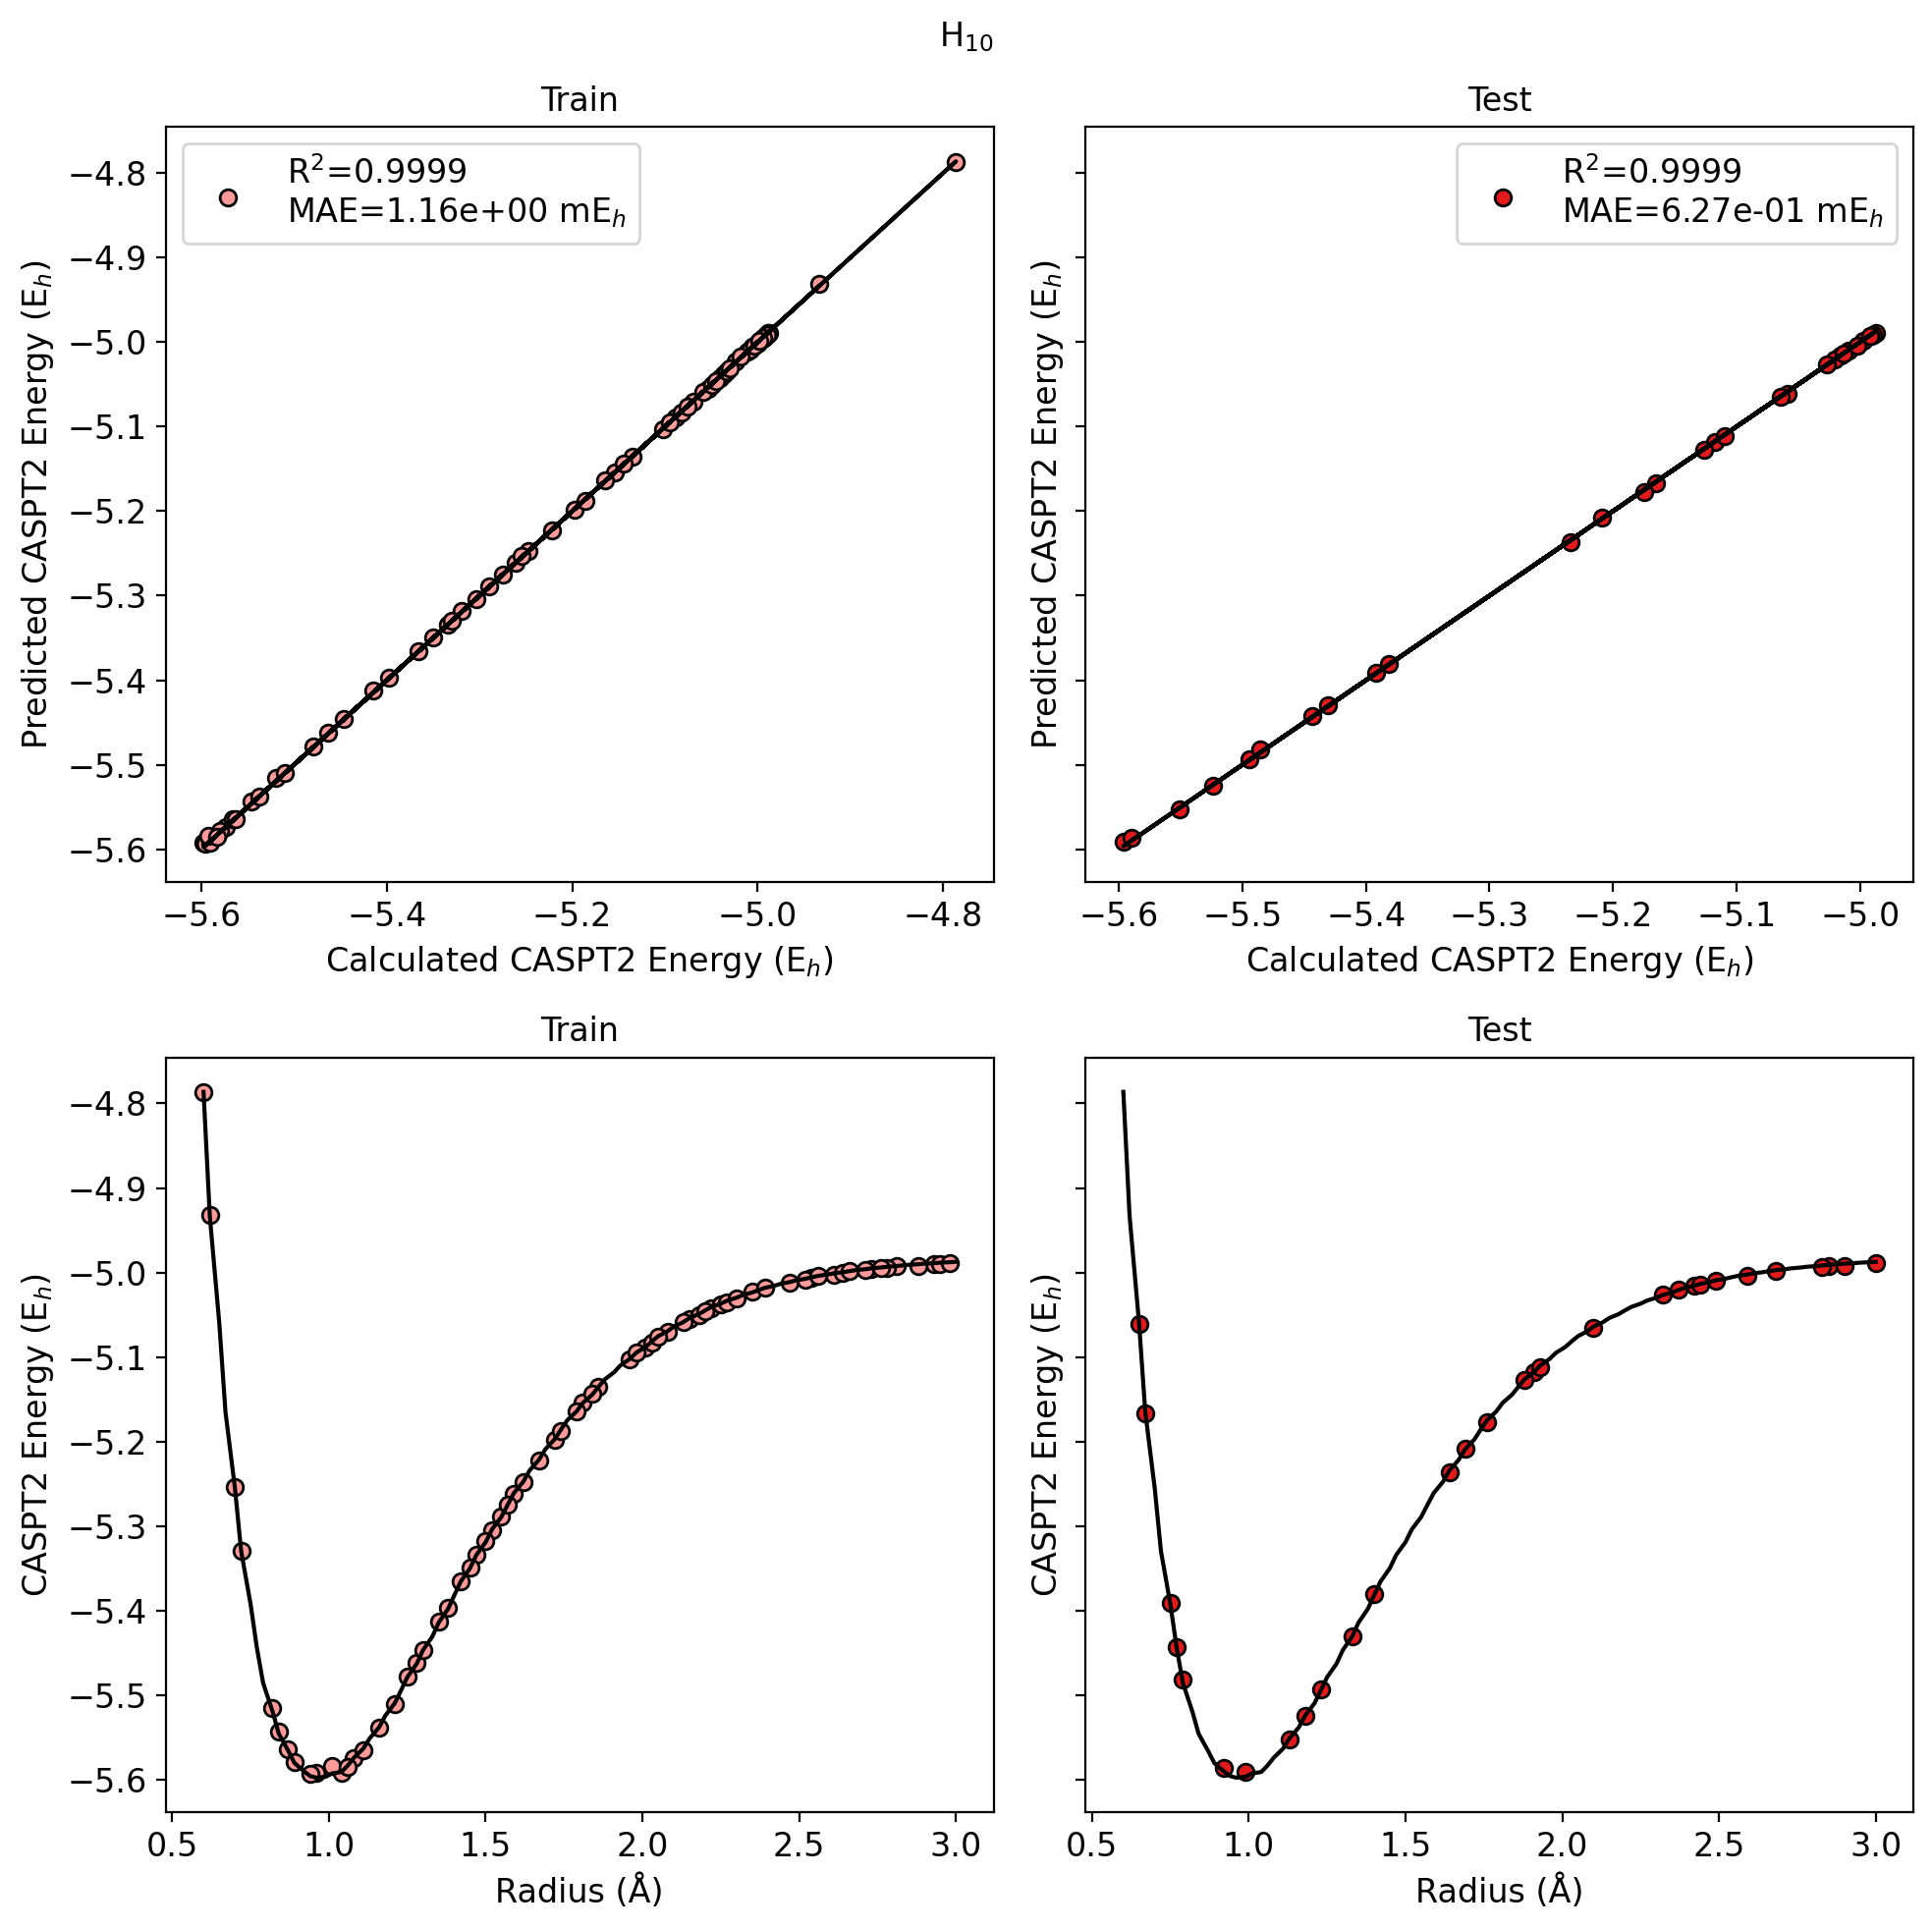

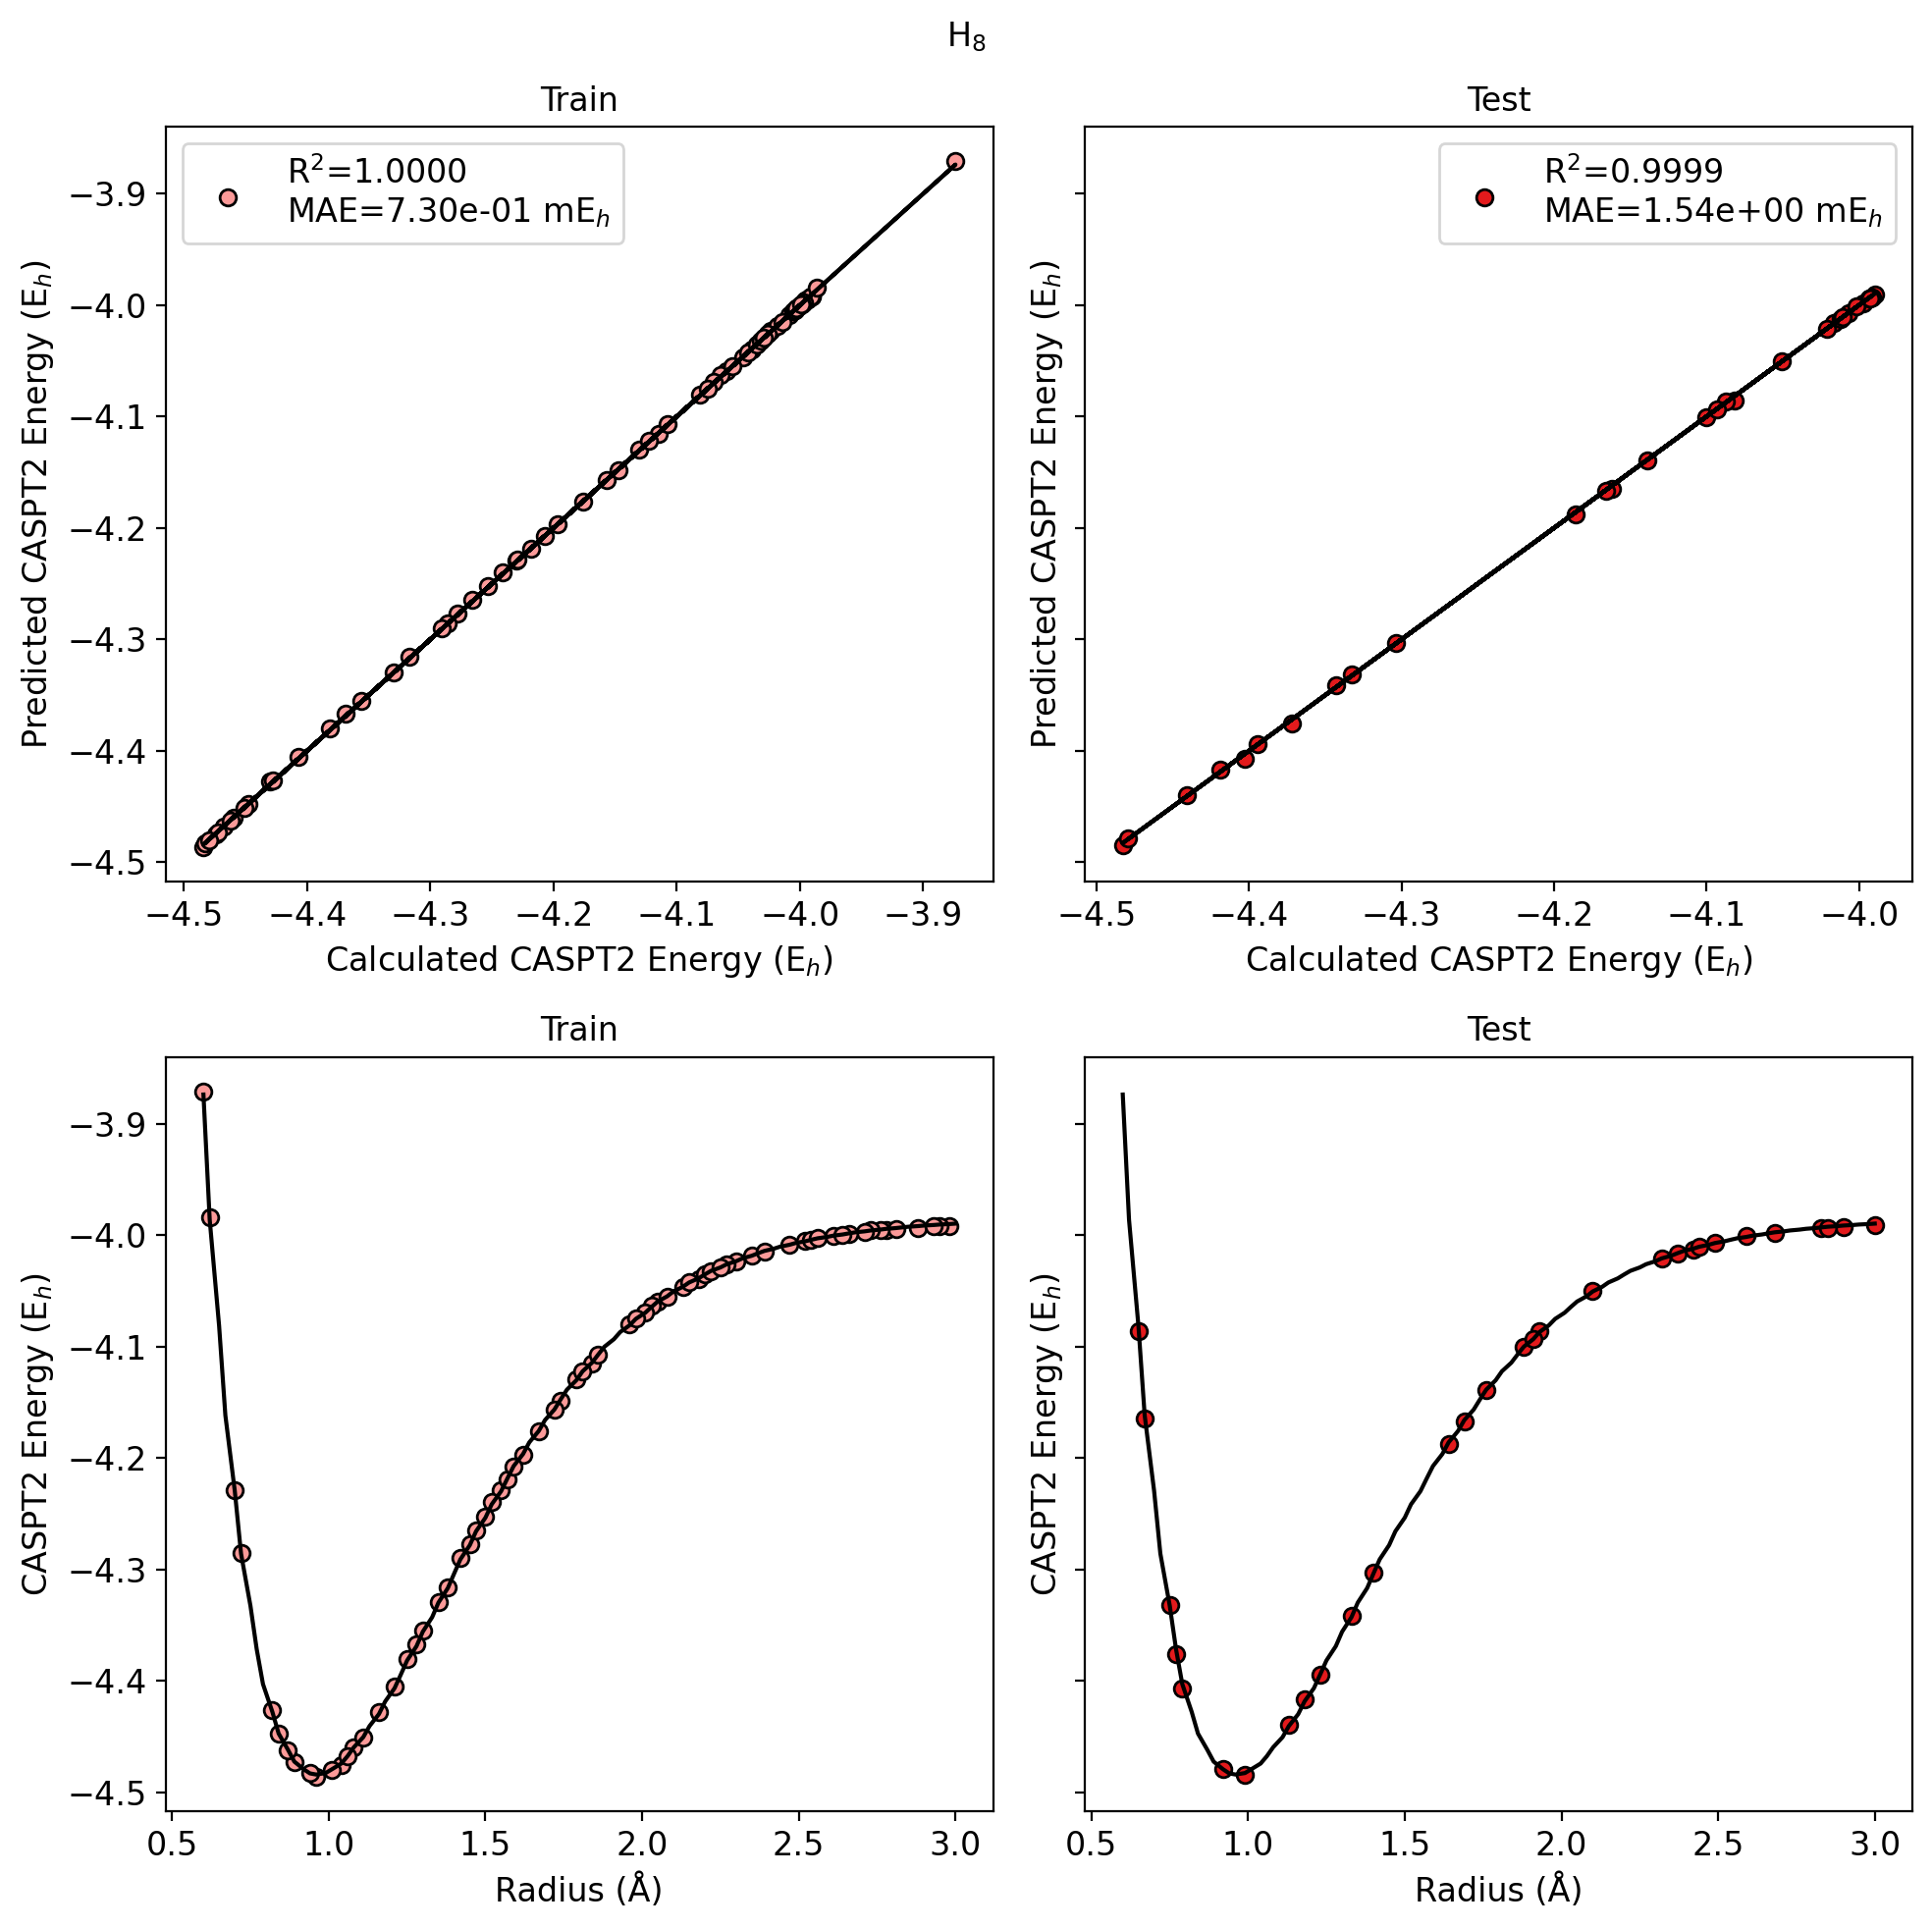

In [182]:
traincorrerr = {}
for n in set(traincaspt2melt['H$_{2n}$']):
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10),sharey=True)
    pred_train,true_train = traincorrE2[traincorrE2['H$_{2n}$']==n]['E$_{\text{CASPT2}}^{\text{Predicted}}$'],traincorrE2[traincorrE2['H$_{2n}$']==n]['E$_{\text{CASPT2}}^{\text{Calculated}}$']
    
    train_r2_corr = r2_score(true_train,pred_train)
    test_r2_corr = r2_score(true_test,pred_test)
    test_mae_corr = 1e3*mean_absolute_error(true_test,pred_test)
    train_mae_corr = 1e3*mean_absolute_error(true_train,pred_train)
    
    traincorrerr[n] = {"r2_train":train_r2_corr,"r2_test":test_r2_corr,"mae_train":train_mae_corr,"mae_test":test_mae_corr}
    trainrad = traincorrE2[traincorrE2['H$_{2n}$']==n]['Radius ($\AA$)']

    ax1.scatter(true_train,pred_train,label='R$^{2}$='+f'{train_r2_corr:.4f}\nMAE={train_mae_corr:.2e}'+" mE$_{h}$",color=pairedcp[4],edgecolors='k')
    ax1.plot(true_train,true_train,'k')
    ax1.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
    ax1.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
    ax1.set_title('Train')
    ax1.legend()

    pred_test,true_test = testcorrE2[testcorrE2['H$_{2n}$']==n]['E$_{\text{CASPT2}}^{\text{Predicted}}$'],testcorrE2[testcorrE2['H$_{2n}$']==n]['E$_{\text{CASPT2}}^{\text{Calculated}}$']
    testrad = testcorrE2[testcorrE2['H$_{2n}$']==n]['Radius ($\AA$)']
    ax2.scatter(true_test,pred_test,label='R$^{2}$='+f'{test_r2_corr:.4f}\nMAE={test_mae_corr:.2e}'+" mE$_{h}$",color=pairedcp[5],edgecolors='k')
    ax2.plot(true_test,true_test,'k')
    ax2.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
    ax2.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
    ax2.set_title('Test')    
    ax2.legend()
    
    ax3.scatter(np.array(trainrad,dtype=float),pred_train,color=pairedcp[4],edgecolors='k')
    ax3.plot(trueE2[trueE2['H$_{2n}$']==n].sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'],trueE2[trueE2['H$_{2n}$']==n].sort_values(by='Radius ($\AA$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'],'k')
    ax3.set_xlabel('Radius (Å)')
    ax3.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax3.set_title('Train')
    
    ax4.scatter(np.array(testrad,dtype=float),pred_test,color=pairedcp[5],edgecolors='k')
    ax4.plot(trueE2[trueE2['H$_{2n}$']==n].sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'],trueE2[trueE2['H$_{2n}$']==n].sort_values(by='Radius ($\AA$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'],'k')
    ax4.set_xlabel('Radius (Å)')
    ax4.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax4.set_title('Test') 

    fig.suptitle("H$_{"+re.findall(r'\d+',n)[0]+"}$")
    
    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    #plt.savefig(f'images/{n}_CASPT2.png',dpi=300,bbox_inches='tight')
    plt.show()    

<Axes: xlabel='index', ylabel='value'>

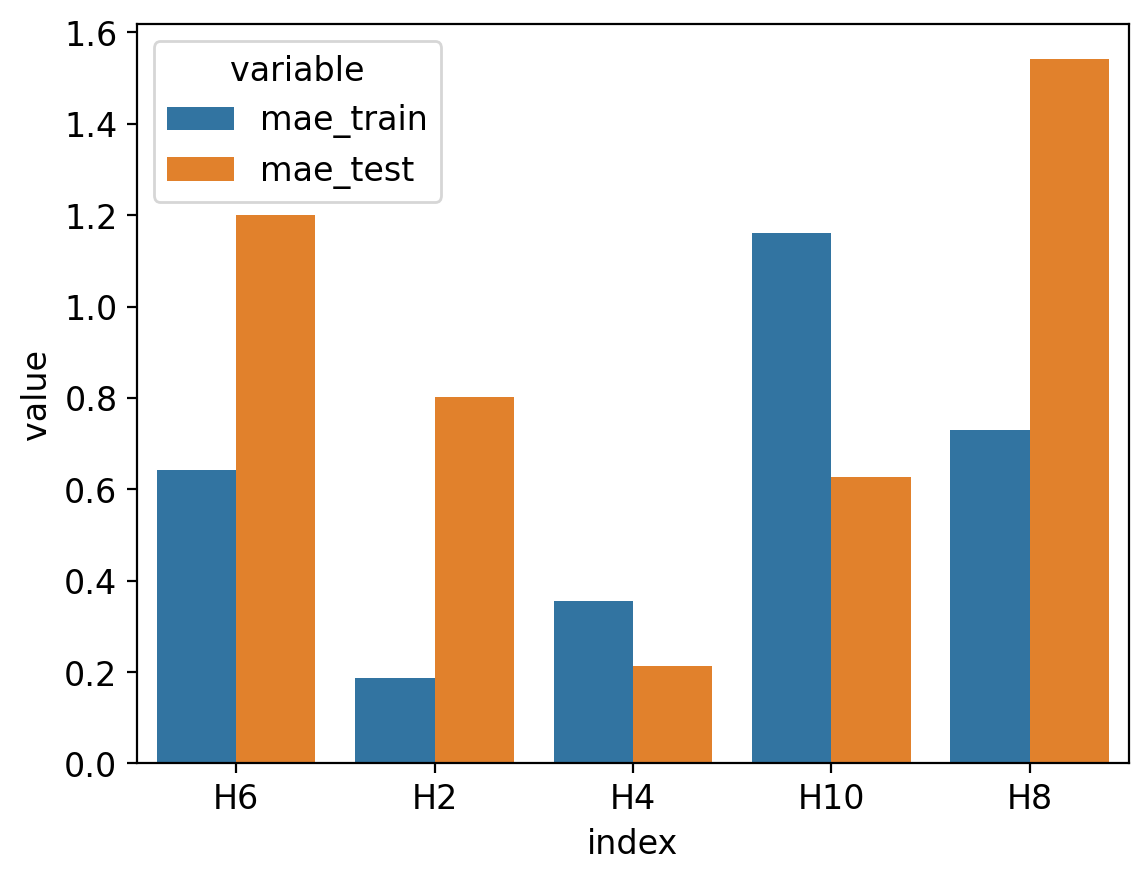

In [194]:
melttraincorrerr = pd.DataFrame.from_dict(traincorrerr).loc[['mae_train','mae_test']].T.reset_index().melt(id_vars=['index'], value_vars=['mae_train','mae_test'])

sns.barplot(data=melttraincorrerr,x='index',y='value',hue='variable')

In [ ]:
for n in test_CASPT2.columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)
    train,test=traincorrdict[n],testcorrdict[n]
    true_train,pred_train=train['train'],train['pred']
    true_test,pred_test=test['test'],test['pred']
    
    ax1.scatter(train.index.astype(float),pred_train*1e3,label='R$^{2}$='+f'{r2_score(true_train,pred_train):.4f}\nMAE={1e3*mean_absolute_error(true_train,pred_train):.2e}'+" mE$_{h}$",color=pairedcp[4],edgecolors='k')
    ax1.plot(E2[n].index.astype(float),E2[n]*1e3,'k')
    ax1.set_xlabel('Radius (Å)')
    ax1.set_ylabel('Correlation Energy (mE$_{h}$)')
    ax1.set_title('Train')
    ax1.legend()
    
    ax2.scatter(test.index.astype(float),pred_test*1e3,label='R$^{2}$='+f'{r2_score(true_test,pred_test):.4f}\nMAE={1e3*mean_absolute_error(true_test,pred_test):.2e}'+" mE$_{h}$",color=pairedcp[5],edgecolors='k')
    ax2.plot(E2[n].index.astype(float),E2[n]*1e3,'k')
    ax2.set_xlabel('Radius (Å)')
    ax2.set_title('Test')
    ax2.legend()
    
    fig.suptitle(n)
    
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.tight_layout()
    #plt.savefig(f'images/{n}_E2.png',dpi=300,bbox_inches='tight')
    plt.show()    

In [ ]:
for n in test_CASPT2.columns:
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10),sharey=True)
    pt2=CASPT2[n]
    true_train,pred_train=pt2.loc[train_CASPT2.index],train_CASPT2[n]
    true_test,pred_test=pt2.loc[test_CASPT2.index],test_CASPT2[n]
    ax1.scatter(true_train,pred_train,label='R$^{2}$='+f'{r2_score(true_train,pred_train):.4f}\nMAE={1e3*mean_absolute_error(true_train,pred_train):.2e}'+" mE$_{h}$",color=pairedcp[4],edgecolors='k')
    ax1.plot(true_train,true_train,'k')
    ax1.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
    ax1.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
    ax1.set_title('Train')
    ax1.legend()

    ax2.scatter(true_test,pred_test,label='R$^{2}$='+f'{r2_score(true_test,pred_test):.4f}\nMAE={1e3*mean_absolute_error(true_test,pred_test):.2e}'+" mE$_{h}$",color=pairedcp[5],edgecolors='k')
    ax2.plot(true_test,true_test,'k')
    ax2.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
    ax2.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
    ax2.set_title('Test')    
    ax2.legend()
    
    ax3.scatter(np.array(pred_train.index,dtype=float),pred_train,color=pairedcp[4],edgecolors='k')
    ax3.plot(np.array(pt2.index,dtype=float),pt2.values,'k')
    ax3.set_xlabel('Radius (Å)')
    ax3.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax3.set_title('Train')
    
    ax4.scatter(np.array(pred_test.index,dtype=float),pred_test,color=pairedcp[5],edgecolors='k')
    ax4.plot(np.array(pt2.index,dtype=float),pt2.values,'k')
    ax4.set_xlabel('Radius (Å)')
    ax4.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax4.set_title('Test')
    
    fig.suptitle(n)
    
    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    #plt.savefig(f'images/{n}_CASPT2.png',dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
testdfcorr=pd.DataFrame.from_dict(testcorr_err,orient='index').rename(columns={0:'test'})
traindfcorr=pd.DataFrame.from_dict(traincorr_err,orient='index').rename(columns={0:'train'})
errormeltcorr=pd.concat([traindfcorr,testdfcorr],axis=1).reset_index().melt(id_vars='index')
errormeltcorr['index']=[i.split('_')[0] for i in errormeltcorr['index']]

In [ ]:
dev=pd.concat([CASPT2[i]-CASSCF[i] for i in sorted(CASSCF.columns,key=lambda x: int(x.strip('H')))],axis=1)

In [ ]:
f"{mean_absolute_error(CASPT2[train_CASPT2.columns].loc[train_CASPT2.index].values.flatten(),train_CASPT2.values.flatten())*1e3:.4f}"

In [ ]:
f"{mean_absolute_error(CASPT2[test_CASPT2.columns].loc[test_CASPT2.index].values.flatten(),test_CASPT2.values.flatten())*1e3:.4f}"

In [ ]:
CASPT2[test_CASPT2.columns].loc[test_CASPT2.index]

In [ ]:
root_mean_squared_error(.values.flatten(),pd.concat([train_CASPT2,test_CASPT2]).sort_index().values.flatten())

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)

sns.barplot(data=errormelt,x='index',y='value',hue='variable',palette=sns.color_palette('Paired'),ax=ax1)
ax1.set_ylabel('Mean Absolute Error (mE$_{h}$)')
ax1.set_xlabel('Structures')
ax1.set_title('Pair-Energies')

sns.barplot(data=errormeltcorr,x='index',y='value',hue='variable',palette=sns.color_palette('Paired'),ax=ax2)
# ax2.set_ylabel('Mean Absolute Error (mE$_{h}$)')
ax2.set_ylabel('')
ax2.set_xlabel('Structures')
ax2.set_title('Correlation Energies')

plt.tight_layout()
#plt.savefig('images/MAE_bar.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# pd.DataFrame(feat_name).to_excel('kept_feat.xlsx')